# Loan Default Prediction

from kaggle:
https://www.kaggle.com/datasets/ajay1735/hmeq-data

##### Context
The consumer credit department of a bank wants to automate the decisionmaking process for approval of home equity lines of credit. To do this, they will follow the recommendations of the Equal Credit Opportunity Act to create an empirically derived and statistically sound credit scoring model. The model will be based on data collected from recent applicants granted credit through the current process of loan underwriting. The model will be built from predictive modeling tools, but the created model must be sufficiently interpretable to provide a reason for any adverse actions (rejections).

##### Content
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable indicating whether an applicant eventually defaulted or was seriously delinquent. This adverse outcome occurred in 1,189 cases (20%). For each applicant, 12 input variables were recorded.

## Import Libraries Needed

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report,roc_curve,auc

# models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

## Read Dataset

In [57]:
df = pd.read_csv('hmeq.csv')
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


## Features

**BAD (Target Variable)**      
1 = client defaulted on loan    
0 = loan repaid

**LOAN**    
Amount of the loan request

**MORTDUE**     
Amount due on existing mortgage

**VALUE**   
Value of current property

**REASON**  
DebtCon = debt consolidation    
HomeImp = home improvement

**JOB**     
Six occupational categories

**YOJ**     
Years at present job

**DEROG**       
Number of major derogatory reports

**DELINQ**      
Number of delinquent credit lines

**CLAGE**   
Age of oldest trade line in months

**NINQ**    
Number of recent credit lines

**CLNO**    
Number of credit lines

**DEBTINC**     
Debt-to-income ratio


## Exploratory Data Analysis (EDA)

### Column Types

In [58]:
df.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

Only 2 categorical columns: REASON & JOB, while others are numerical columns. We will need to encode categorical columns into numerical later.

### Null Ratio

In [59]:
null_ratio = {}

for column in df.columns:
    null_ratio[column] = round(df[column].isnull().sum()/df.shape[0],2)

null_ratio

{'BAD': 0.0,
 'LOAN': 0.0,
 'MORTDUE': 0.09,
 'VALUE': 0.02,
 'REASON': 0.04,
 'JOB': 0.05,
 'YOJ': 0.09,
 'DEROG': 0.12,
 'DELINQ': 0.1,
 'CLAGE': 0.05,
 'NINQ': 0.09,
 'CLNO': 0.04,
 'DEBTINC': 0.21}

### Target Column Proportion

In [60]:
df.BAD.value_counts(normalize=True)

0    0.800503
1    0.199497
Name: BAD, dtype: float64

### Value Counts for Categorical Columns

In [61]:
for column in df.columns:
    if df[column].dtype == "object":
        print(f'{column} feature count: ')
        print(df[column].value_counts(normalize=True))
        print()

REASON feature count: 
DebtCon    0.688157
HomeImp    0.311843
Name: REASON, dtype: float64

JOB feature count: 
Other      0.420349
ProfExe    0.224608
Office     0.166872
Mgr        0.135011
Self       0.033973
Sales      0.019187
Name: JOB, dtype: float64



### Statistical Summary for Numerical Columns

In [62]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


### Get More Info on EDA

In [63]:
# Get Column EDA and store in dict
dtypes_dict = {}
shortest_dict = {}
longest_dict = {}
isnull_dict = {}
unique_dict = {}
memory_dict = {}

for column in df.columns:
    dtypes_dict[column] = df[column].dtype
    shortest_dict[column] = df[column].astype(str).str.len().min()
    longest_dict[column] = df[column].astype(str).str.len().max()
    isnull_dict[column] = df[column].isnull().sum()
    unique_dict[column] = df[column].nunique()
    memory_dict[column] = df[column].memory_usage()

### EDA Consolidation

In [64]:
columns_info = ['data_types','shortest_length','longest_length','null_values','unique_values','memory_usage','count','mean','std','min','25%','median','75%','max']

df1 = pd.DataFrame(dtypes_dict ,index=[0]).T
df2 = pd.DataFrame(shortest_dict ,index=[0]).T
df3 = pd.DataFrame(longest_dict,index=[0]).T
df4 = pd.DataFrame(isnull_dict,index=[0]).T
df5 = pd.DataFrame(unique_dict,index=[0]).T
df6 = pd.DataFrame(memory_dict,index=[0]).T

desc = df.describe().T

eda_df = pd.concat([df1,df2,df3,df4,df5,df6,desc], axis=1)
eda_df.columns = columns_info
eda_df['variance'] = eda_df.apply(lambda row: round(row['std'] ** 2, 2) , axis = 1)
eda_df

,data_types,shortest_length,longest_length,null_values,unique_values,memory_usage,count,mean,std,min,25%,median,75%,max,variance
BAD,int64,1,1,0,2,47808,5960.0,0.199497,0.399656,0.000000,0.000000,0.000000,0.000000,1.000000,1.600000e-01
LOAN,int64,4,5,0,540,47808,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000,1.256076e+08
MORTDUE,float64,3,9,518,5053,47808,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000,1.976479e+09
VALUE,float64,3,8,112,5381,47808,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000,3.293127e+09
REASON,object,3,7,252,2,47808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JOB,object,3,7,279,6,47808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YOJ,float64,3,4,515,99,47808,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000,5.737000e+01
DEROG,float64,3,4,708,11,47808,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000,7.200000e-01
DELINQ,float64,3,4,580,14,47808,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000,1.270000e+00
CLAGE,float64,3,12,308,5314,47808,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561,7.363370e+03


### Pairplot

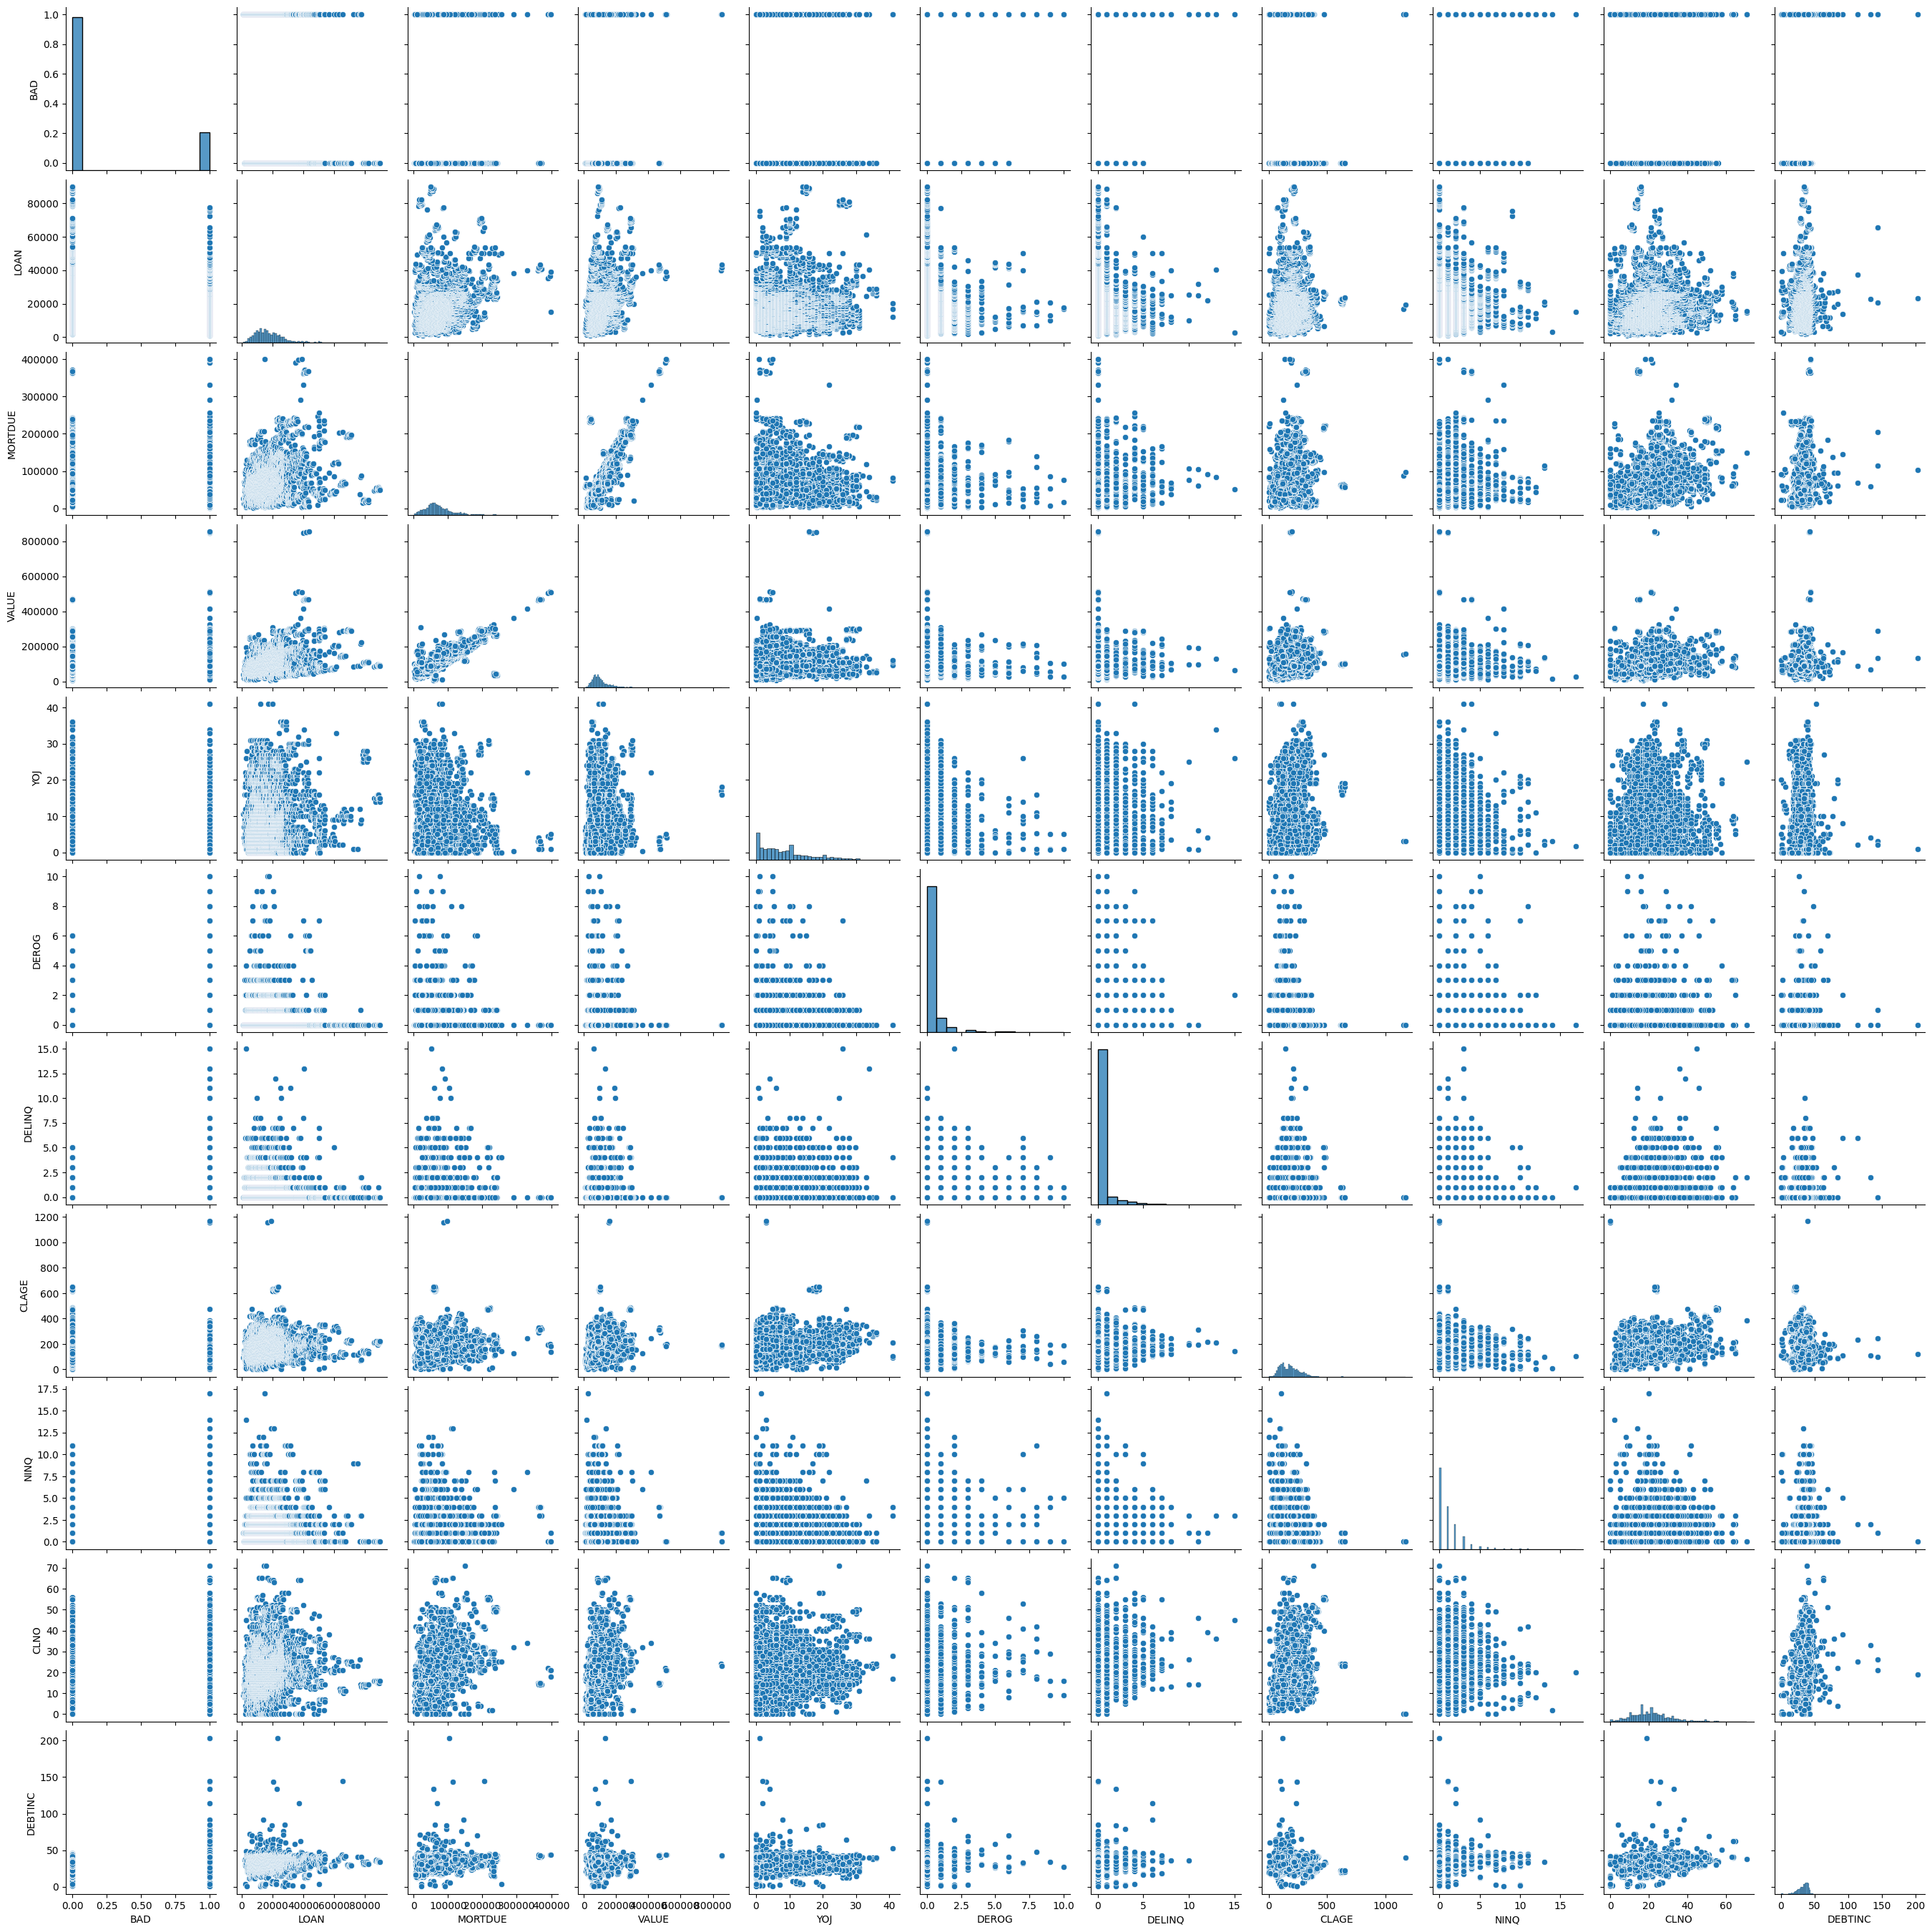

In [65]:
sns.pairplot(df)

### Correlation between Columns

In [66]:
df.corr()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
BAD,1.000000,-0.075099,-0.048219,-0.029954,-0.060238,0.276081,0.354107,-0.170499,0.174980,-0.004157,0.199835
LOAN,-0.075099,1.000000,0.228595,0.335393,0.105728,-0.001302,-0.035144,0.088540,0.044487,0.072631,0.084735
MORTDUE,-0.048219,0.228595,1.000000,0.875666,-0.088480,-0.049516,-0.001044,0.140047,0.031392,0.323631,0.154939
VALUE,-0.029954,0.335393,0.875666,1.000000,0.007759,-0.048689,-0.014103,0.171238,-0.004398,0.269149,0.132174
YOJ,-0.060238,0.105728,-0.088480,0.007759,1.000000,-0.065879,0.038153,0.201718,-0.071627,0.024838,-0.055891
DEROG,0.276081,-0.001302,-0.049516,-0.048689,-0.065879,1.000000,0.211832,-0.083047,0.173934,0.061884,0.017065
DELINQ,0.354107,-0.035144,-0.001044,-0.014103,0.038153,0.211832,1.000000,0.022488,0.067812,0.164639,0.052364
CLAGE,-0.170499,0.088540,0.140047,0.171238,0.201718,-0.083047,0.022488,1.000000,-0.116935,0.237987,-0.046477
NINQ,0.174980,0.044487,0.031392,-0.004398,-0.071627,0.173934,0.067812,-0.116935,1.000000,0.088389,0.141344
CLNO,-0.004157,0.072631,0.323631,0.269149,0.024838,0.061884,0.164639,0.237987,0.088389,1.000000,0.185539


From -1 to 1, the positive value shows there is a postivie correlation between each other and vice versa.

### EDA Inference

1. We have 2 categorical columns for our features: REASON & JOB. Since both are **Nominal Variables**, we will need to use One Hot Encoder to encode them later.
2. Based on the count, all of the columns have relatively lesser null values(<50%). Hence, we will not drop any columns for this part.
3. Our target column: BAD is imbalanced, only 20% of the data are True while the rest are False.
4. BAD and LOAN are the only 2 columns that do not hold any missing values.
5. Most people applied loan due to the reason "Debt Consolidation".
6. Based on the dataset, the most common job found is 'OTHER'.
7. The middle 50% range(interquartile-range) of people had loan amount between 11.1k to 23.3k.
8. Based on the variance of each column, we see that the feature 'DEROG' has low variance, which implies that the feature is approximately constant. We can consider to remove it as it will not bring significant impact to the outcome of model.
9. Based on pairplot and correlation between features, we found that the feature 'NINQ' and 'CLNO' have strong correlation, hence we will drop either one to reduce the complexity of model.

## Feature Selection

In [67]:
# Based on the EDA, we will drop features 'DEROG' and 'CLNO'. 

df = df.drop(columns=['DEROG','CLNO'])

## Remove Duplicates

In [68]:
df = df.drop_duplicates()

## Fill Empty Values

For MORTDUE, we assume there is no ammount due hence we fill 0.     
For VALUE, we assume there is input error hence we fill the mean.   
For REASON, we assume there is input error hence we fill the mode.  
For JOB, we assume the applicant is jobless hence we fill 'Unemployed'.     
For YOJ, we assume unemployment or not reach 1 year yet hence we fill 0.    
For DELINQ, we assume there is no delinquent credit lines hence we fill 0.  
For CLAGE, we assume there is no old trade line hence we fill 0.    
For NINQ, we assume there is no recent credit lines hence we fill 0.    
For DEBTINC, we assume there is no debt hence we fill 0.    

In [69]:
df['MORTDUE'] = df['MORTDUE'].fillna(0)
df['VALUE'] = df['VALUE'].fillna(round(df['VALUE'].mean()))
df['REASON'] = df['REASON'].fillna(df['REASON'].mode()[0])
df['JOB'] = df['JOB'].fillna('Unemployed')
df['YOJ'] = df['YOJ'].fillna(0)
df['DELINQ'] = df['DELINQ'].fillna(0)
df['CLAGE'] = df['CLAGE'].fillna(0)
df['NINQ'] = df['NINQ'].fillna(0)
df['DEBTINC'] = df['DEBTINC'].fillna(0)

## Encode Categorical Columns

In [70]:
df = pd.get_dummies(df, columns = ['REASON','JOB'])

## Splitting the Dataset

In [71]:
X = df.drop(['BAD'], axis=1)
y = df.BAD

# split with train-test ratio of 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7) 

## Model Training

### Machine Learning Models

In [72]:
def assess_model(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print(f'{model_name}:')
    print(classification_report(y_test, model.predict(X_test)))
    print(f'AUC-ROC: {auc(fpr, tpr)}')

In [73]:
# Logistic Regression

lr = LogisticRegression()
assess_model(lr, "Logistic Regression")


Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1446
           1       0.70      0.23      0.34       342

    accuracy                           0.83      1788
   macro avg       0.77      0.60      0.62      1788
weighted avg       0.82      0.83      0.80      1788

AUC-ROC: 0.6026242993375555


In [74]:
# Naive Bayes

nb = GaussianNB()
assess_model(nb, "Naive Bayes")

Naive Bayes:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1446
           1       0.70      0.61      0.65       342

    accuracy                           0.87      1788
   macro avg       0.80      0.78      0.79      1788
weighted avg       0.87      0.87      0.87      1788

AUC-ROC: 0.7752056489772149


In [75]:
# Stochastic Gradient Descent

sgd = SGDClassifier(loss='log_loss')
assess_model(sgd, "Stochatic Gradient Descent")

Stochatic Gradient Descent:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1446
           1       0.11      0.01      0.03       342

    accuracy                           0.79      1788
   macro avg       0.46      0.49      0.45      1788
weighted avg       0.67      0.79      0.72      1788

AUC-ROC: 0.49313290140981775


In [76]:
# K Nearest Neighbours

knn = KNeighborsClassifier()
assess_model(knn, "K Nearest Neighbours")


K Nearest Neighbours:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1446
           1       0.55      0.23      0.32       342

    accuracy                           0.82      1788
   macro avg       0.70      0.59      0.61      1788
weighted avg       0.78      0.82      0.79      1788

AUC-ROC: 0.5922508553541531


In [77]:
# Decision Tree

dtree = DecisionTreeClassifier()
assess_model(dtree, "Decision Tree")

Decision Tree:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1446
           1       0.64      0.63      0.64       342

    accuracy                           0.86      1788
   macro avg       0.78      0.77      0.78      1788
weighted avg       0.86      0.86      0.86      1788

AUC-ROC: 0.7746414792167139


In [78]:
# Random Forest

rf = RandomForestClassifier()
assess_model(rf, "Random Forest")

Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1446
           1       0.82      0.68      0.74       342

    accuracy                           0.91      1788
   macro avg       0.87      0.82      0.84      1788
weighted avg       0.91      0.91      0.91      1788

AUC-ROC: 0.8197386620077165


In [79]:
# Support Vector Machine

svm = SVC(probability=True)
assess_model(svm, "Support Vector Machine")

Support Vector Machine:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1446
           1       1.00      0.01      0.02       342

    accuracy                           0.81      1788
   macro avg       0.91      0.50      0.46      1788
weighted avg       0.85      0.81      0.73      1788

AUC-ROC: 0.5043859649122807


In [80]:
# Gradient Boost

gb = GradientBoostingClassifier()
assess_model(gb, "Gradient Boost")

Gradient Boost:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1446
           1       0.81      0.65      0.72       342

    accuracy                           0.90      1788
   macro avg       0.86      0.81      0.83      1788
weighted avg       0.90      0.90      0.90      1788

AUC-ROC: 0.8076969741088544


In [81]:
# Adaptive Boosting (AdaBoost)

ab = AdaBoostClassifier()
assess_model(ab, "Ada Boost")

Ada Boost:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1446
           1       0.77      0.61      0.69       342

    accuracy                           0.89      1788
   macro avg       0.84      0.79      0.81      1788
weighted avg       0.89      0.89      0.89      1788

AUC-ROC: 0.7859248744267309


In [82]:
#  XG Boost

xgb = XGBClassifier()
# objective="binary:logistic"   
assess_model(xgb, "XG Boost")

XG Boost:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1446
           1       0.81      0.70      0.75       342

    accuracy                           0.91      1788
   macro avg       0.87      0.83      0.85      1788
weighted avg       0.91      0.91      0.91      1788

AUC-ROC: 0.8315134308801049


### Neural Network

In [83]:
mlp = MLPClassifier()
# objective="binary:logistic"   
assess_model(mlp, "Multiple Layer Perceptron")

Multiple Layer Perceptron:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1446
           1       0.68      0.06      0.11       342

    accuracy                           0.81      1788
   macro avg       0.75      0.53      0.50      1788
weighted avg       0.79      0.81      0.75      1788

AUC-ROC: 0.5272439397248307


## Model Selection

Since our dataset is **imbalance**, Accuracy cannot be used as the main evaluation metric. Hence, we will focus more on F1(the harmonic mean of Precision and Recall) and AUC of ROC. Based on the confusion matrix and AUC-ROC score, the most promising model is Extreme Gradient Boosting (XGBoost). Next, we are going to further tune this model.

## Hyperparameter Tuning